<a href="https://colab.research.google.com/github/Trapezun/skillfactory_rds/blob/master/project_module_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np
import missingno as msno


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [39]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/skillfactory project 2/stud_math.xls')
pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

# Первичный осмотр данных

In [4]:
display(data.shape)

(395, 30)

Итого у нас 395 записей всего

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Имеем много колонок с числовыми данными и колонок с текстовыми данными. Почти все колонки имеют пустные значения. Надо будет их обработать перед анализом

Переименую колонку чтобы было удобнее

In [40]:
data = data.rename(columns={"studytime, granular": "granular"})

# Рассмотрим количество пустых значений

Узнаем для начала в процентном отношении сколько вообще пустых значений в каждой колонке

In [7]:
np.round(data.isna().sum()[data.isna().sum()>0] / data.shape[0], 2)

address       0.04
famsize       0.07
Pstatus       0.11
Medu          0.01
Fedu          0.06
Mjob          0.05
Fjob          0.09
reason        0.04
guardian      0.08
traveltime    0.07
studytime     0.02
failures      0.06
schoolsup     0.02
famsup        0.10
paid          0.10
activities    0.04
nursery       0.04
granular      0.02
higher        0.05
internet      0.09
romantic      0.08
famrel        0.07
freetime      0.03
goout         0.02
health        0.04
absences      0.03
score         0.02
dtype: float64

Для всех признаков сначала попробуем дропнуть строки с пропущенными значениями и посмотрим, сколько данных останется:


In [8]:
data.dropna().shape[0] / data.shape[0]

0.24556962025316456

Просто так удалить не получится. Надо обрабатывать каждую колонку по отдельности. 
Покажем пустые значение более наглядно

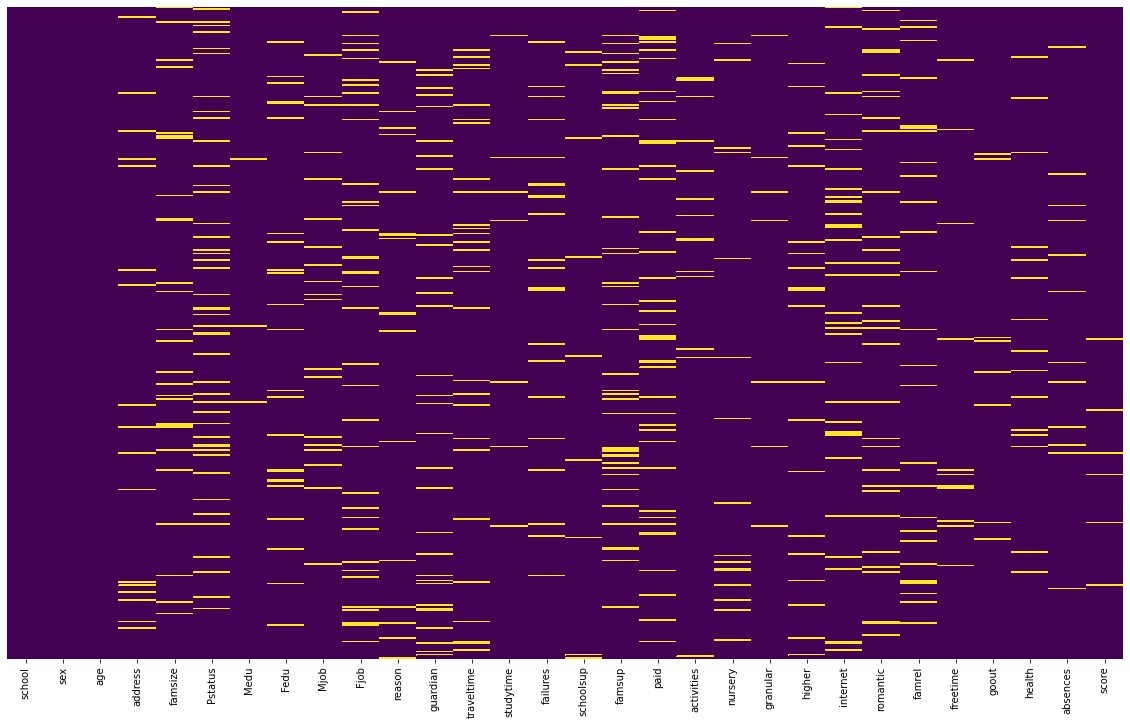

In [25]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')


Видим не очень приятную картину. Хотя пропусков не много, но они есть почти в каждой колонке. 

**Важный момент.**  В колонке score тоже есть пустый значения. Их надо удалить тк для нас эти записи безполезны


In [41]:
nul =  data[data.score.isnull()].index.tolist()
data = data.drop(nul)


# Смотрим корреляцию между колонками


Перед тем как работать с численными колонками посмотрим на корреляцию с колонкой **score**.

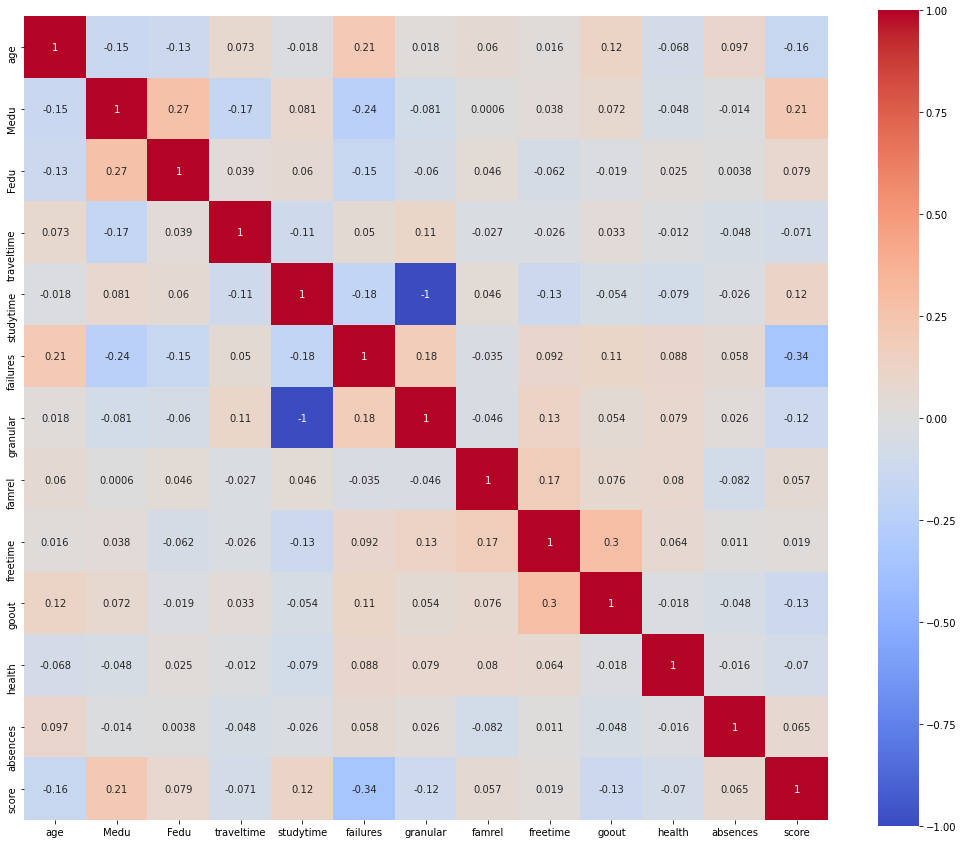

In [ ]:
plt.subplots(figsize=(18,15))
sns.heatmap(data.corr(),annot=True, square=True, cmap=sns.color_palette("coolwarm", 10000), vmin=-1, center=0)
plt.show()

 Как видно, колонка **granular** и **studytime** полностью коррелированы. Удалю **granular**. 
 

In [42]:
data = data.drop('granular', 1)


# Заполняем пустые числовые значения

Для каждой колонки будут свои значения, которы заменят пустые

**Колонки Medu, Fedu, traveltime, famrel, freetime, health, absences,studytime,failures, goout** - беру среднее



In [52]:
def fillMean(column):
  mean = data[column].mean()
  data[column] = data[column].fillna(mean)

list_of_cols = ['Medu', 'Fedu','traveltime', 'famrel', 'freetime', 'health', 'absences','studytime','failures','goout']
for item in list_of_cols:
  fillMean(item)


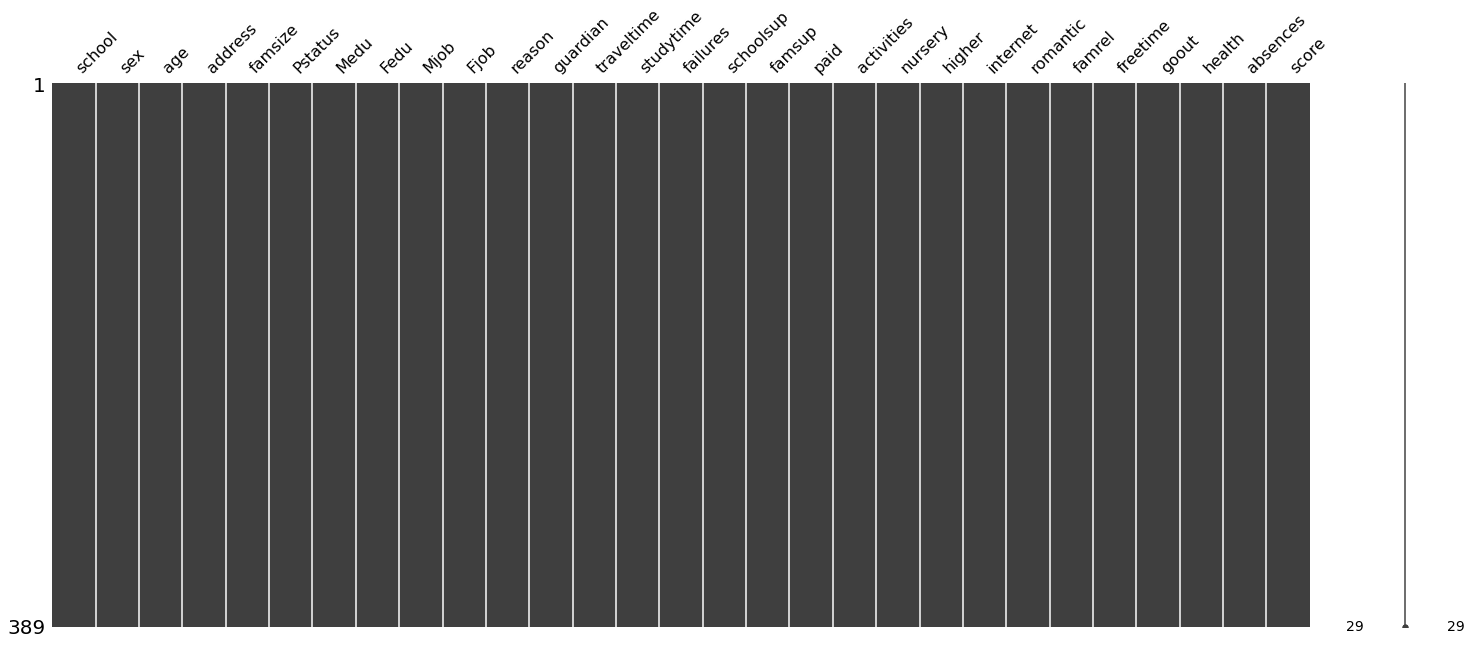

In [59]:
msno.matrix(data)

# Рассмотрим разброс числовых значений

In [54]:
def bar(column):  
  plt.figure(figsize=(5,2))
  sns.boxplot(data[column])

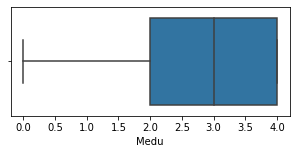

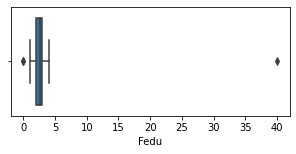

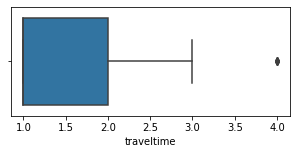

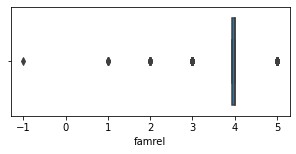

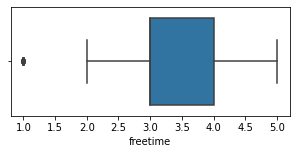

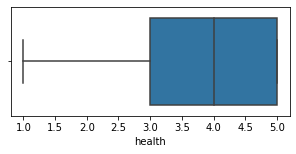

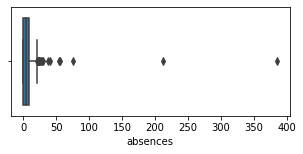

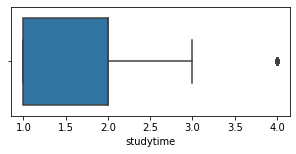

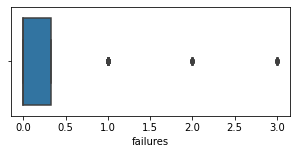

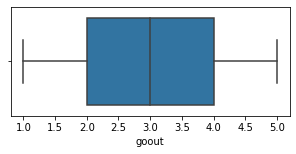

In [55]:
for item in list_of_cols:
   bar(item)   

Работаем с **Fedu**

In [60]:
data["Fedu"].value_counts()

2.000000     105
3.000000      94
4.000000      88
1.000000      75
2.627397      24
0.000000       2
40.000000      1
Name: Fedu, dtype: int64

Уберем значения 0 и 40

In [64]:
delFedu = data[(data['Fedu']==0) | (data['Fedu']==40) ].index.tolist()
data = data.drop(delFedu)


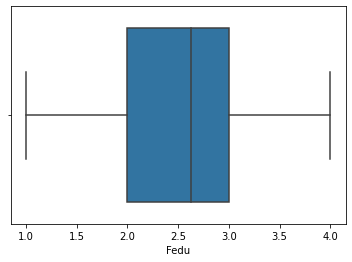

In [66]:
 sns.boxplot(data['Fedu'])

Работаем с **traveltime** 

In [68]:
data["traveltime"].value_counts()

1.000000    239
2.000000     92
1.434903     28
3.000000     20
4.000000      7
Name: traveltime, dtype: int64

In [69]:
delTraveltime = data[(data['traveltime']==4)].index.tolist()
data = data.drop(delTraveltime)

Работаю с **famrel** 

In [71]:
data["famrel"].value_counts()

 4.000000    173
 5.000000     94
 3.000000     61
 3.930939     27
 2.000000     17
 1.000000      6
-1.000000      1
Name: famrel, dtype: int64

Удалю только то, что равно -1, остальные оставлю


In [72]:
delFamrel = data[(data['famrel']==-1)].index.tolist()
data = data.drop(delFamrel)

Работаю с  **freetime**

In [74]:
data["freetime"].value_counts()

3.000000    147
4.000000    108
2.000000     61
5.000000     35
1.000000     18
3.223684      9
Name: freetime, dtype: int64

Странное значение 3.223684. Удалю его


In [79]:
delFreetime = data[(data['freetime']>3) & (data['freetime']<4)].index.tolist()
data = data.drop(delFreetime)

In [80]:
data["freetime"].value_counts()

3.0    147
4.0    108
2.0     61
5.0     35
1.0     18
Name: freetime, dtype: int64

Работаю с **absences** 

In [84]:
data["absences"].value_counts()

0.000000      105
2.000000       58
4.000000       51
6.000000       28
8.000000       18
10.000000      17
12.000000      12
7.320106       11
14.000000       9
16.000000       7
3.000000        7
5.000000        5
18.000000       5
7.000000        5
9.000000        3
20.000000       3
22.000000       3
1.000000        3
13.000000       2
15.000000       2
56.000000       1
19.000000       1
26.000000       1
24.000000       1
38.000000       1
28.000000       1
25.000000       1
40.000000       1
385.000000      1
75.000000       1
23.000000       1
11.000000       1
17.000000       1
212.000000      1
21.000000       1
Name: absences, dtype: int64

In [85]:
median = data["absences"].median()
IQR = data["absences"].quantile(0.75) - data["absences"].quantile(0.25)
perc25 = data["absences"].quantile(0.25)
perc75 = data["absences"].quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


Удаляю все что больше 20. И странное значение 7.320106

In [ ]:
delAbsences = data[(data['absences']>20)].index.tolist()
data = data.drop(delAbsences)

delAbsences = data[(data['absences']>7) & (data['absences']<8)].index.tolist()
data = data.drop(delAbsences)


Работаю с **studytime**

In [94]:
data["studytime"].value_counts()

2.000000    168
1.000000     91
3.000000     56
4.000000     24
2.036649      4
Name: studytime, dtype: int64

Удалю 2.036649

In [95]:
delStudytime = data[(data['studytime']>2) & (data['studytime']<3)].index.tolist()
data = data.drop(delStudytime)

Работаю с **failures** 

In [96]:
data["failures"].value_counts()

0.000000    260
1.000000     41
0.326975     16
2.000000     11
3.000000     11
Name: failures, dtype: int64

Удалю 0.326975

In [97]:
delFailures = data[(data['failures']>0) & (data['failures']<1)].index.tolist()
data = data.drop(delFailures)

# Заполняем пустые номинативные значения

In [112]:
colsnum = data.select_dtypes(include='object').columns.tolist()

['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [108]:
data.select_dtypes(include='object').describe()

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,323,323,323,323,323,323,323,323,323,323,323,323,323,323,323,323,323
unique,2,2,3,3,3,6,6,5,4,3,3,3,3,3,3,3,3
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,281,171,241,214,263,111,161,114,203,275,180,165,162,247,298,244,201


Судя по данным в них нет не стандартных значений. Поэтмому просто заменим все пустоты на слово None


In [113]:
for col in colsnum:
  data[col] = data[col].astype(str).apply(lambda x: None if pd.isnull(x) else x)

In [106]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index)],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

def get_stat_dif(column):
    cols = data.loc[:, column].value_counts().index    
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:              
        ind = ttest_ind(data.loc[data.loc[:, column] == comb[0], 'score'], 
                        data.loc[data.loc[:, column] == comb[1], 'score'])

        if ind.pvalue <= 0.05/len(combinations_all): # Учли поправку Бонферони            
            print(ind)

            print('Найдены статистически значимые различия для колонки', column)
            break

Рассмотрим распределение **score** в зависимости от значения переменных

In [117]:
for col in colsnum:
    #get_boxplot(col)
    get_stat_dif(col)



Ttest_indResult(statistic=-2.309882885444423, pvalue=0.021528719881201464)
Найдены статистически значимые различия для колонки sex
Ttest_indResult(statistic=2.7328851852467495, pvalue=0.006642148772041484)
Найдены статистически значимые различия для колонки address
Ttest_indResult(statistic=-3.113289279559609, pvalue=0.0026190123482948513)
Найдены статистически значимые различия для колонки Mjob
Ttest_indResult(statistic=2.6140860762799876, pvalue=0.009384894156114062)
Найдены статистически значимые различия для колонки higher


У нас получилось, что есть статистически значимые различия для колонок sex, address, Mjob, и higher


Выделим колонки, которые влияют на **score**

In [119]:
data_for_model = data.loc[:,  ['age','Medu','Fedu','studytime','failures','goout','traveltime', 'famrel', 'freetime', 'health', 'absences', 'higher', 'sex','address', 'Mjob', 'score']]
data_for_model.head() 

,age,Medu,Fedu,studytime,failures,goout,traveltime,famrel,freetime,health,absences,higher,sex,address,Mjob,score
0,18,4.0,4.0,2.0,0.0,4.0,2.0,4.0,3.0,3.0,6.0,yes,F,U,at_home,30.0
1,17,1.0,1.0,2.0,0.0,3.0,1.0,5.0,3.0,3.0,4.0,yes,F,U,at_home,30.0
2,15,1.0,1.0,2.0,3.0,2.0,1.0,4.0,3.0,3.0,10.0,yes,F,U,at_home,50.0
3,15,4.0,2.0,3.0,0.0,2.0,1.0,3.0,2.0,5.0,2.0,yes,F,U,health,75.0
4,16,3.0,3.0,2.0,0.0,2.0,1.0,4.0,3.0,5.0,4.0,yes,F,U,other,50.0


# Выводы

Итак, в результате EDA для анализа влияния условий жизни учащихся на успеваемость по математике были получены следующие выводы:

1. С пустыми значениями следующая ситуация. В каждой характеристике  их не много, но они есть почти у каждой. Тк данных не очень много, то нельзя просто так взять и выкинуть сточку с пустыми значениями. Пришлось их заполнять промежуточными данными без потери корреляции со score

2. Были обнаружены пустые значения в столбце score. Такие строчки пришлось удалить. 

3. В данных были обнаружены выборосы, а так же не корректные данные (дробные числа вместо целых)

4. Интересна прямая корреляция итоговых оценок со следующими параметрами

Medu — образование матери - чем выше, тем лучше. 

studytime - чем выше, тем лучше учеба

failures — сильное влияние

goout — чем больше проводит время с друзьями, тем хуже учеба

higher - важно, тк желание получить высшее образование тянет за собой желание 
поулчать хорошие оценки

sex  - у мальчиков оценки выше

address - кто из города у того оценки выше

Mjob - у кого мама имеет хорошую работу, у того оценки выше






Краткий вывод такой - чтобы лучше учиться нужно желание получить высшее образование и больше времени учелять учебе. Так же крайне важно сглаживать последствия внеучебных неудач. 
Кроме того, важно какое образование у родителей.
